In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize
import os
from PIL import Image
import glob
import subprocess
import matplotlib as mpl
import gc
import matplotlib
import seaborn as sns
from sklearn.metrics import mean_squared_error
import emcee


os.makedirs("frames", exist_ok=True)
def run(phi,theta,radii):
    # ---- fibonacci sphere ----
    def fibonacci_sphere(n_points):
        """generating equal points to distributing in sphere"""
        indices = np.arange(n_points, dtype=float) + 0.5
        phi = np.arccos(1 - 2*indices/n_points)  # [0, π]
        theta = np.pi * (1 + 5**0.5) * indices  # aureo angle
        
        return phi, theta % (2*np.pi)  # etting values between 0 and 2π
    
    def cartesian_from_spherical(phi, theta, r=1.0):
        """Convert spherical coordinates to cartesians"""
        x = r * np.sin(phi) * np.cos(theta)
        y = r * np.sin(phi) * np.sin(theta)
        z = r * np.cos(phi)
        return x, y, z
    
    def spot_mask_geodesic(x, y, z, spot_center, spot_radius_rad):
        """Máscara usando distancia geodésica real con optimización"""
        # Convert the spot_center vector to a unit vector (of length 1).
        center_norm = spot_center / np.linalg.norm(spot_center)
        
        # Product
        positions = np.stack([x, y, z], axis=-1)
        norms = np.linalg.norm(positions, axis=-1, keepdims=True)
        pos_norm = positions / np.clip(norms, 1e-10, None)  #np.clip avoids division by zero (if a vector had length 0).
        
        dot_product = np.sum(pos_norm * center_norm, axis=-1) #Calculation of the Product Point
        dot_product = np.clip(dot_product, -1, 1) #Force the values to be between [-1, 1]. This is necessary because numerical errors may produce values slightly outside this range.
        
        # central_angle is the geodesic distance (in radians) between each point on the surface and the center of the spot.
        central_angle = np.arccos(dot_product)
        
        return np.exp(-(central_angle**2) / (2 * spot_radius_rad**2))
    
    #function to calculate angular velocity  
    def spot_theta(rotation_period, spot_colatitude, relative_shear):
        ''' Parameters:
        - rotation_period: rotation period of the sta
        - spot_colatitude: latitud of spot(radians)
        - relative_shear: parameter between pole and equator
        Returns:
        - angular velocity. '''
        
        latitude = np.pi / 2 - spot_colatitude
        angular_vel_equa = 2*np.pi*u.rad/rotation_period
        angular_velocity = angular_vel_equa*(1-relative_shear*np.sin(latitude)**2)
        return angular_velocity
    
    def limbdarkening(u, mu):
        ''' lineal limb darkening'''
        return (1 - u * (1 - mu))
    
    def quadratic(u1, u2, mu):
        return 1-u1*(1-mu)-u2*(1-mu)**2
        
    
    def add_spots(latitude_deg, longitude_deg, radii_deg):
        colatitude_rad = np.deg2rad(90 - latitude_deg)
        longitude_rad = np.deg2rad(longitude_deg)
        radii_rad = np.deg2rad(radii_deg)
        ang_vel = spot_theta(rotation_period, colatitude_rad, 0.4)  
        spots.append({
            'theta': longitude_rad * u.rad,
            'phi': colatitude_rad,
            'radius': radii_rad,
            'angular_velocity': ang_vel
        })
    
    def gif(input_pattern="frames/frame_%05d.png", output_gif="output.gif", 
            palette="palette.png", framerate=17):
        palette_cmd = [
            "ffmpeg", "-y", "-i", input_pattern,
            "-vf", "palettegen", palette
        ]
        gif_cmd = [
            "ffmpeg", "-y", "-framerate", str(framerate),
            "-i", input_pattern, "-i", palette,
            "-lavfi", "paletteuse", output_gif
        ]
        try:
            subprocess.run(palette_cmd, check=True)
            subprocess.run(gif_cmd, check=True)
            print(f"GIF creado: {output_gif}")
        except subprocess.CalledProcessError as e:
            print("Error en ffmpeg:", e)
    
    def flux_plot():
        '''
        Function take a list normalizing the flux, converting the list in a csv file and rename the columns
        and return a plot 
    
        '''
        frame_files = sorted(glob.glob("frames/frame_*.png"))
        fluxes = []
    
        for filename in frame_files:
            img = Image.open(filename).convert('L')  # Grayscale
            img_array = np.array(img, dtype=np.float64)
            flux_total = np.sum(img_array)
            fluxes.append(flux_total)
    
        # Normalized fluxes
        #flux_norm.append(flux_total / fluxes[i])
        flux_norm = normalize([fluxes], norm="max")[0]
        #flux_norm = np.array(fluxes)/np.max(np.array(fluxes))
        df = pd.DataFrame(flux_norm)
    
        # Creating columns
        df.index.name = 'Frame'
        df.reset_index(inplace=True)
        #changing frames for days
        df['Days'] = df['Frame'] *(cadence_time.to(u.day)).value
        df = df.rename(columns={0: 'flux_normalized'})
        df = df[['Days', 'flux_normalized']]  
    
        # saving csv
        df.to_csv(f'lat_{(90 - np.rad2deg(spots[0]["phi"])):.1f}_lon{(np.rad2deg(spots[0]["theta"]).value):.1f}_radii{np.rad2deg(spots[0]["radius"])}.csv', index=False)
        #df.to_csv("test.csv", index=False)
        # plotting
        
        ax = df.plot(x="Days", y="flux_normalized", alpha=0.5, linestyle='--', color ="k")
        ax.set_xlabel("Time [days]")
        ax.set_ylabel("Normalized Flux")
        ax.set_title("Lightcurve from PNG frames")
        plt.style.use('default')
        plt.tight_layout()
        plt.savefig(f'lat_{(90 - np.rad2deg(spots[0]["phi"])):.1f}_lon{(np.rad2deg(spots[0]["theta"]).value):.1f}_radii{np.rad2deg(spots[0]["radius"])}.png', dpi=600)
        plt.show()
    
    # ---- Función de animación corregida ----
    def animate(i, points, base_intensity, ax_sphere, elev, azim, total_frames, vmin, vmax):
        ax_sphere.clear()
        ax_sphere.set_axis_off()
        ax_sphere.view_init(elev=elev, azim=azim)
        
        # copying the texture
    
        intensity = np.copy(base_intensity)
        
        # adding several spots
        for spot in spots:
            # Calcular nueva posición de la mancha
            theta_mov = spot['theta'] + spot['angular_velocity'] * i * cadence_time.to(u.day)
            
            # Calculating position of the spot
            spot_x = r_val * np.sin(spot['phi']) * np.cos(theta_mov.value)
            spot_y = r_val * np.sin(spot['phi']) * np.sin(theta_mov.value)
            spot_z = r_val * np.cos(spot['phi'])
            spot_center = np.array([spot_x, spot_y, spot_z])
            
            # creating a mask
            mask = spot_mask_geodesic(points[:, 0], points[:, 1], points[:, 2], 
                                     spot_center, spot['radius'])
            intensity *= (1 -  mask)  # Reducción de intensidad en manchas
        
        # scatter plot 
        sc = ax_sphere.scatter(
            points[:, 0], points[:, 1], points[:, 2], 
            #c=intensity,
            c=np.clip(intensity, 0, 1),
            cmap='gray', 
            s=1, 
            alpha=1,
            vmin=0,  # Mínimo fijo
            vmax=1.0   # Máximo fijo
        )
        
        # Configurar límites de la esfera
        max_range = r_val * 1.1
        ax_sphere.set_xlim(-max_range, max_range)
        ax_sphere.set_ylim(-max_range, max_range)
        ax_sphere.set_zlim(-max_range, max_range)
        
        print(f"Procesando frame {i+1}/{total_frames}", end='\r')
        plt.savefig(f"frames/frame_{i:05d}.png", dpi=300, bbox_inches='tight')
        
        return None
    
    # ---- main ----
    if __name__ == '__main__':
        # stellar parameter
        r_val = 1.0
        n_points = 50000
        u1 = 0.4
        u2 =0.3# limb darkening coefficients
        rotation_period = 1.0 * u.day
        
        # Point of view
        elev = 0
        azim = 0
        
        # List of spots
        spots = []
        
        #adding spots
        add_spots(*vec)      
        #add_spots(-50, 0, 20.5)     
        #add_spots(0, 0, 20)  
        #add_spots(50, 240, 10.5) 
        
        # base lines time parameter
        observing_baseline_days = 1 * u.day
        cadence_time = 50 * u.minute
        total_frames = int((observing_baseline_days / cadence_time).decompose().value)
        
        # spherical grid with fibonacci points
        print("Generate spherical grid...")
        phi, theta = fibonacci_sphere(n_points)
        x, y, z = cartesian_from_spherical(phi, theta)
        points = np.vstack([x, y, z]).T
        
        # Calculate point of view
        elev_rad = np.deg2rad(elev) #elevation of point of view
        azim_rad = np.deg2rad(azim)#azimut of point of view
        
        v_x = np.cos(elev_rad) * np.cos(azim_rad)
        v_y = np.cos(elev_rad) * np.sin(azim_rad)
        v_z = np.sin(elev_rad)
        
        # rearrange of calculating mu parameter for limb darkening
        mu = (points[:, 0] * v_x + points[:, 1] * v_y + points[:, 2] * v_z) / r_val
        mu = np.clip(mu, 0, 1)
        #base_intensity = limbdarkening(constant, mu)# applying to the texture
        base_intensity = quadratic(u1,u2,mu) 
        #    Calculates the extreme values of the base intensity: 
        #vmin: Minimum value of intensity in the whole star.
        #vmax: Maximum value of intensity over the whole star.
        vmin=  0.0
        vmax=  1.0
    
       # Defines a reference range for color mapping that will be used consistently across all frames.
     
        
        # background configurations
        plt.style.use('dark_background')
        fig = plt.figure(figsize=(10, 8))
        ax_sphere = fig.add_subplot(111, projection='3d') 
        ax_sphere.set_axis_off()
        ax_sphere.set_box_aspect([1, 1, 1])
        
        #Límits
        max_range = r_val * 1.1
        ax_sphere.set_xlim(-max_range, max_range)
        ax_sphere.set_ylim(-max_range, max_range)
        ax_sphere.set_zlim(-max_range, max_range)
        
        # Generating animation
        print("start render...")
        for i in range(total_frames):
            animate(i, points, base_intensity, ax_sphere,  elev, azim, total_frames, vmin, vmax)
    
        
        # Create gif an light curve
        #print("\nCreando GIF...")
        #gif(input_pattern="frames/frame_%05d.png", output_gif=f"period_{rotation_period}_points{n_points}_obs{observing_baseline_days}_cadence{cadence_time}_nspots{len(spots)}.gif", framerate=15)
        print("Generating ligthcurve..")
        plt.style.use('default')
        flux_plot()
    


In [9]:
vec = (30, 60, 25)

Generate spherical grid...
start render...
Generating ligthcurve..


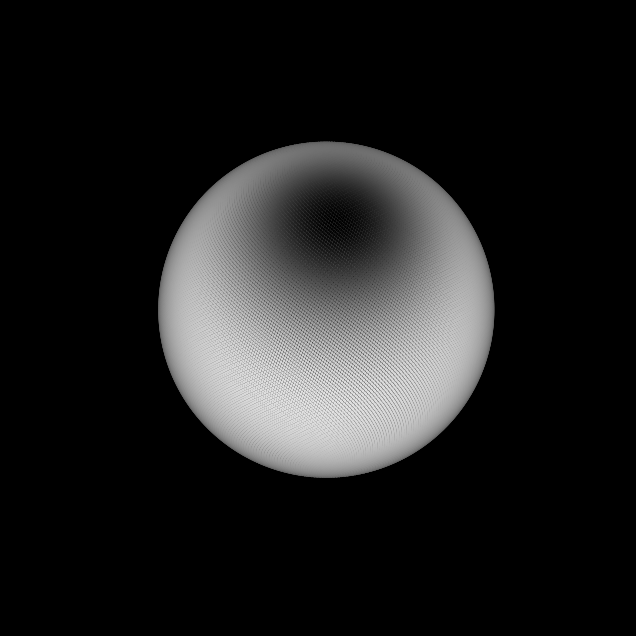

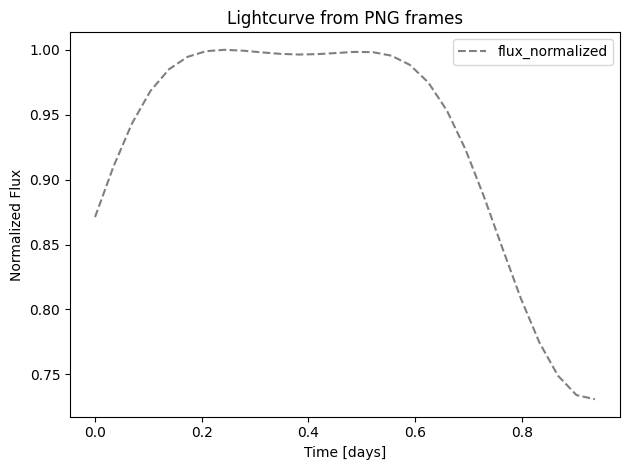

In [10]:
run(*vec)

In [4]:
# Carga de archivos
csv1 = "test.csv"
csv2 = f"lat_{float(vec[0])}_lon{float(vec[1])}_radii{float(vec[2])}.csv"

df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)
F = df1["flux_normalized"]
days =df1["Days"]


📉 MSE entre las curvas: 1.874284443007261e-05


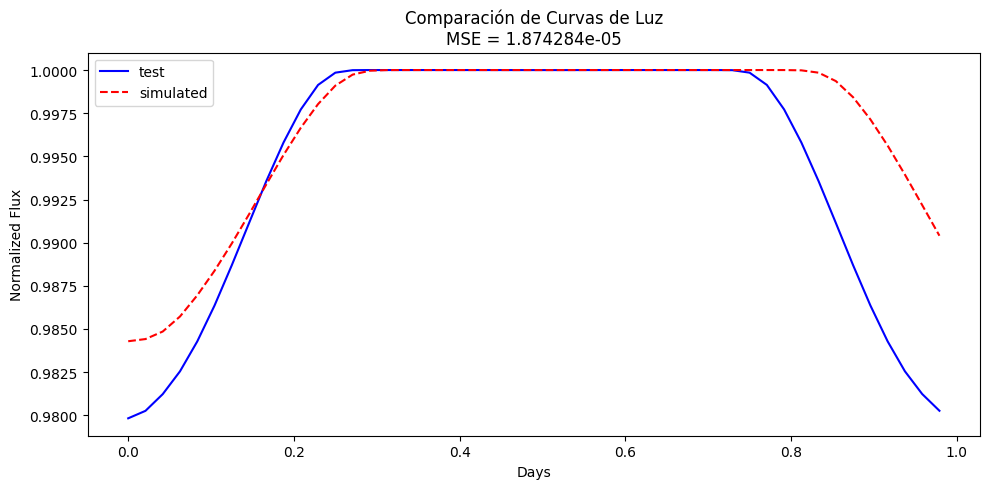

In [5]:

# Calcular MSE
mse = mean_squared_error(df1["flux_normalized"], df2["flux_normalized"])
print(f"📉 MSE entre las curvas: {mse:.15e}")

# Opcional: graficar las curvas
plt.figure(figsize=(10, 5))
plt.plot(df1["Days"], df1["flux_normalized"], label='test', color='blue')
plt.plot(df2["Days"], df2["flux_normalized"], label='simulated', color='red', linestyle='--')
plt.title(f"Comparación de Curvas de Luz\nMSE = {mse:.6e}")
plt.xlabel("Days")
plt.ylabel("Normalized Flux")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
def inlike(lc1,lc2):
    csv1 = f"{lc1}.csv"
    csv2 = f"{lc2}.csv"
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)
    mse = mean_squared_error(df1["flux_normalized"], df2["flux_normalized"])
    print(f"📉 MSE entre las curvas: {mse:.15e}")
    sns.set_theme(style="darkgrid")
# Crear la figura
    plt.figure(figsize=(10, 6))
    
    # Graficar ambas series
    sns.lineplot(x=df1["Days"], y=df1["flux_normalized"], label="Test")
    sns.lineplot(x=df2["Days"], y=df2["flux_normalized"], label="Simulated")
    
    # Personalizar
    plt.title("Light-curve Comparison")
    plt.xlabel("Days")
    plt.ylabel("Flux Normalized")
    plt.legend()
    
    # Mostrar gráfico
    plt.show()
    return mse


📉 MSE entre las curvas: 1.874284443007261e-05


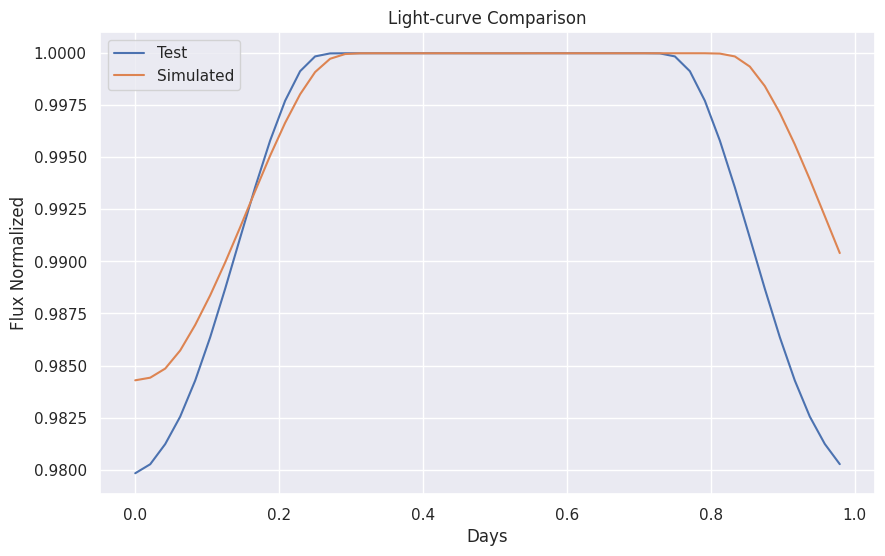

1.8742844430072607e-05

In [126]:
inlike("test",f"lat_{float(vec[0])}_lon{float(vec[1])}_radii{float(vec[2])}")

📉 MSE entre las curvas: 1.874284443007261e-05


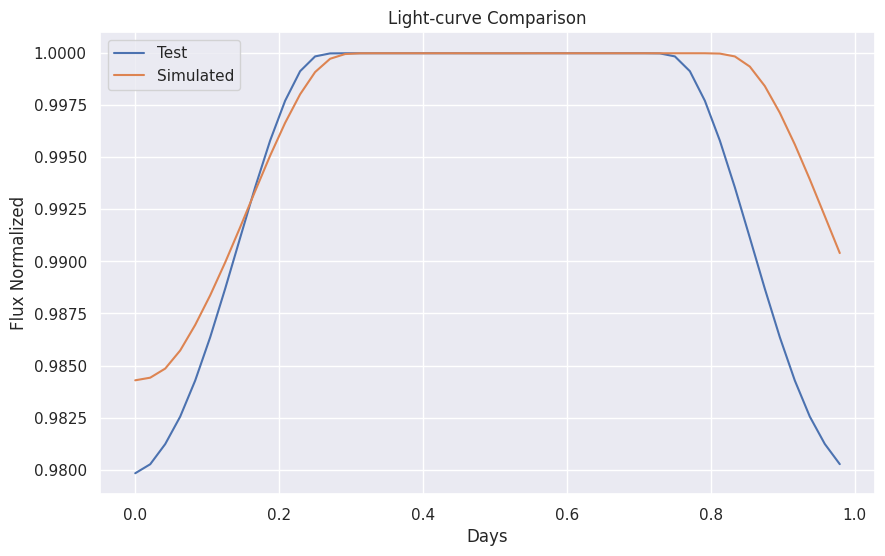

In [127]:
l = inlike("test",f"lat_{float(vec[0])}_lon{float(vec[1])}_radii{float(vec[2])}")

In [7]:
def lnprior(vec):
    lat, lon, radii = vec
    if -90.0 <= lat <= 90.0 and 0.0 <= lon <= 360.0 and 0.1 <= radii <= 50.0:
        return 0.0
    return -np.inf



In [8]:
lnprior(vec)

0.0

In [9]:
def lnprob(vec,lc1,lc2):
    lp = lnprior(vec)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(lc1,lc2)



In [10]:
Ferr = 0.005*np.mean(F)
data = (days,F,Ferr)
nwalkers = 128
niter = 500
initial = np.array([0, 0, 1.0])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]



In [13]:

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state



In [14]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)



Running burn-in...
emcee: Exception while calling your likelihood function:
  params: [1.18076571e-07 4.49047094e-08 9.99999963e-01]
  args: (0     0.000000
1     0.020833
2     0.041667
3     0.062500
4     0.083333
5     0.104167
6     0.125000
7     0.145833
8     0.166667
9     0.187500
10    0.208333
11    0.229167
12    0.250000
13    0.270833
14    0.291667
15    0.312500
16    0.333333
17    0.354167
18    0.375000
19    0.395833
20    0.416667
21    0.437500
22    0.458333
23    0.479167
24    0.500000
25    0.520833
26    0.541667
27    0.562500
28    0.583333
29    0.604167
30    0.625000
31    0.645833
32    0.666667
33    0.687500
34    0.708333
35    0.729167
36    0.750000
37    0.770833
38    0.791667
39    0.812500
40    0.833333
41    0.854167
42    0.875000
43    0.895833
44    0.916667
45    0.937500
46    0.958333
47    0.979167
Name: Days, dtype: float64, 0     0.979824
1     0.980257
2     0.981225
3     0.982546
4     0.984278
5     0.986356
6     0.988690
7    

Traceback (most recent call last):
  File "/home/ruben/miniconda3/envs/tesis/lib/python3.10/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
TypeError: lnprob() takes 3 positional arguments but 4 were given


TypeError: lnprob() takes 3 positional arguments but 4 were given

Running burn-in...
Generate spherical grid...
start render...
Generating ligthcurve..


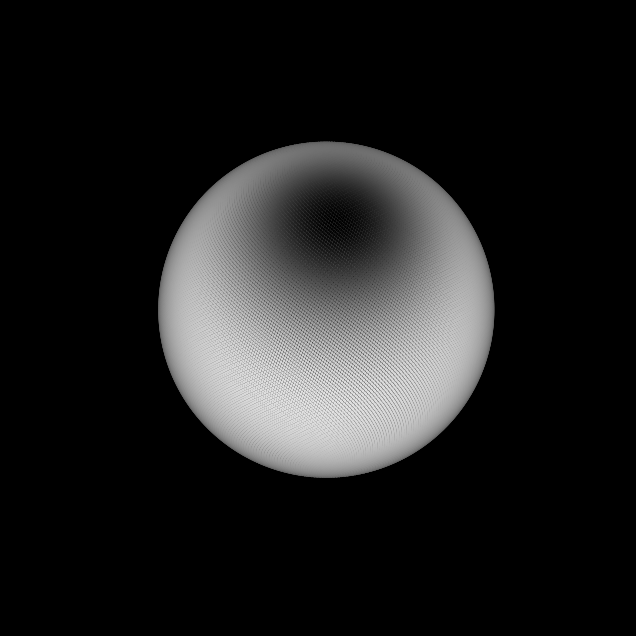

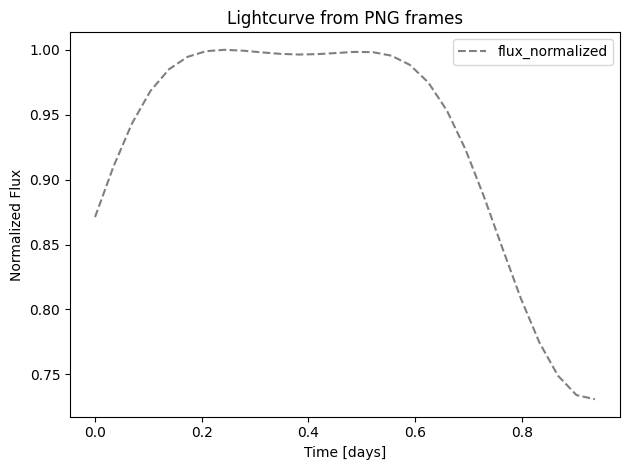

Generate spherical grid...
start render...
Generating ligthcurve..


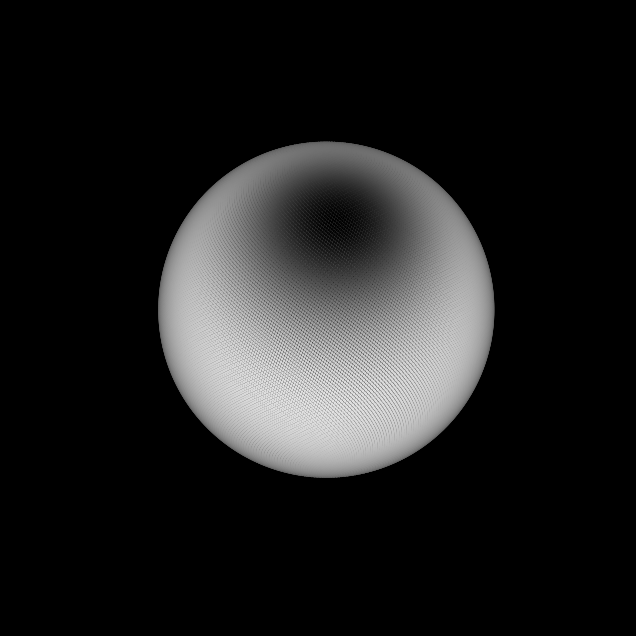

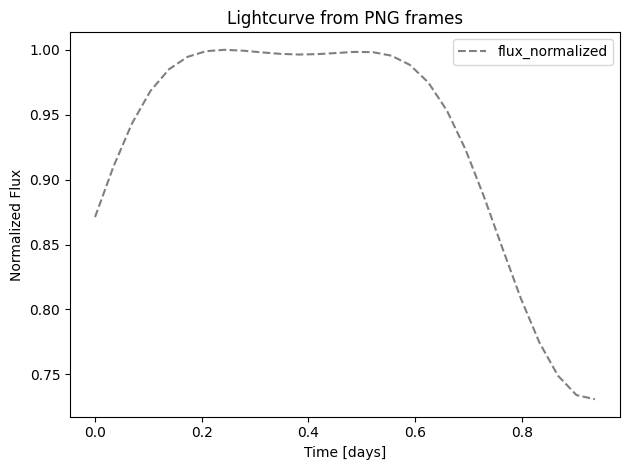

Generate spherical grid...
start render...
Generating ligthcurve..


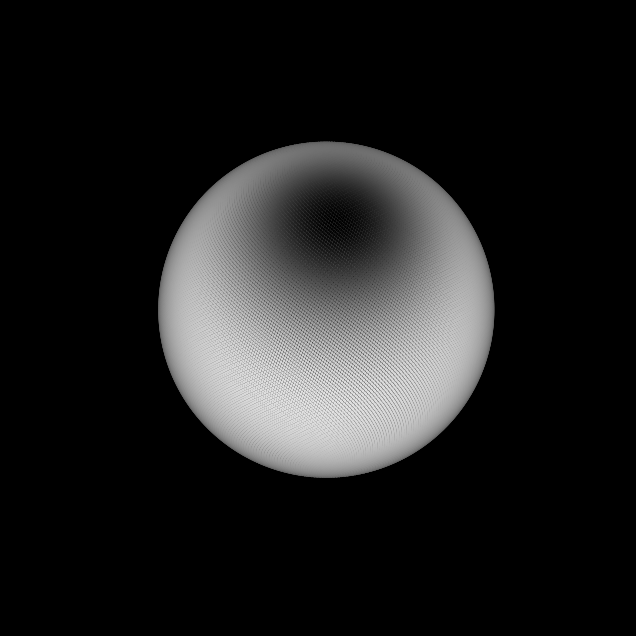

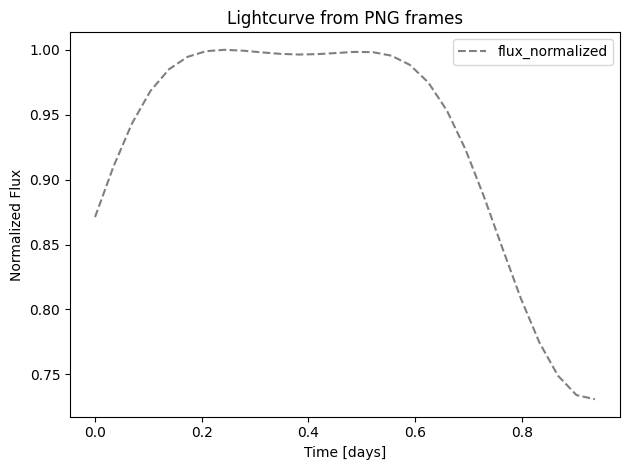

Generate spherical grid...
start render...
Generating ligthcurve..


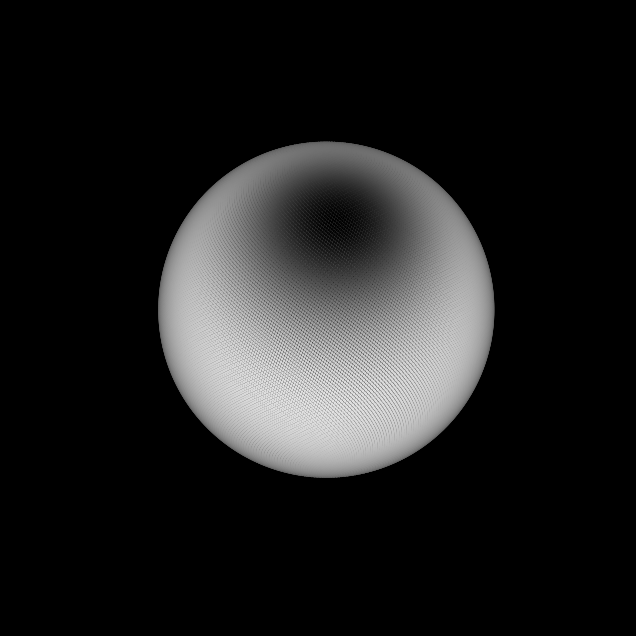

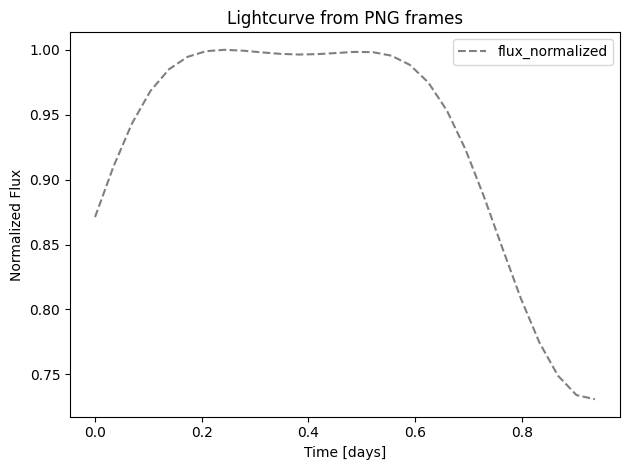

Generate spherical grid...
start render...
Generating ligthcurve..


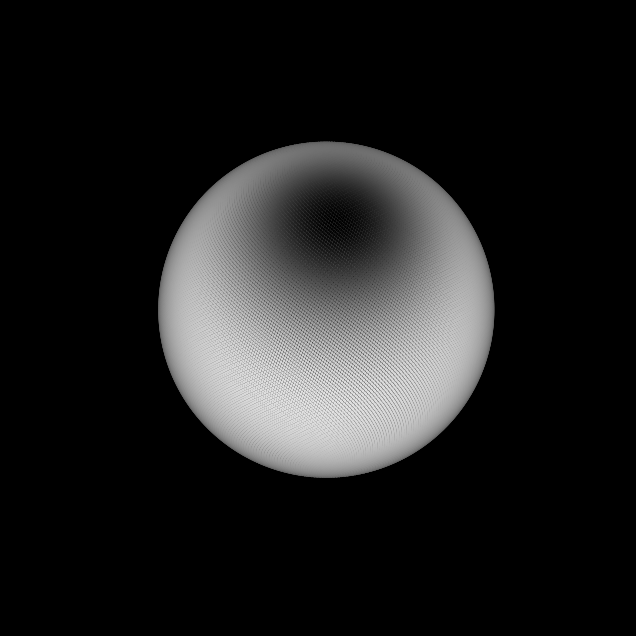

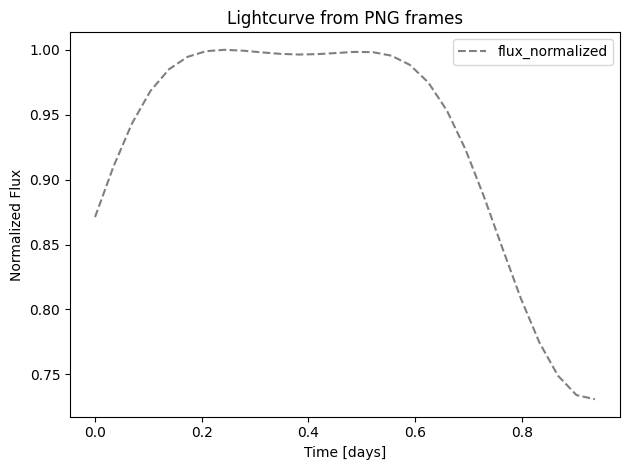

Generate spherical grid...
start render...
Generating ligthcurve..


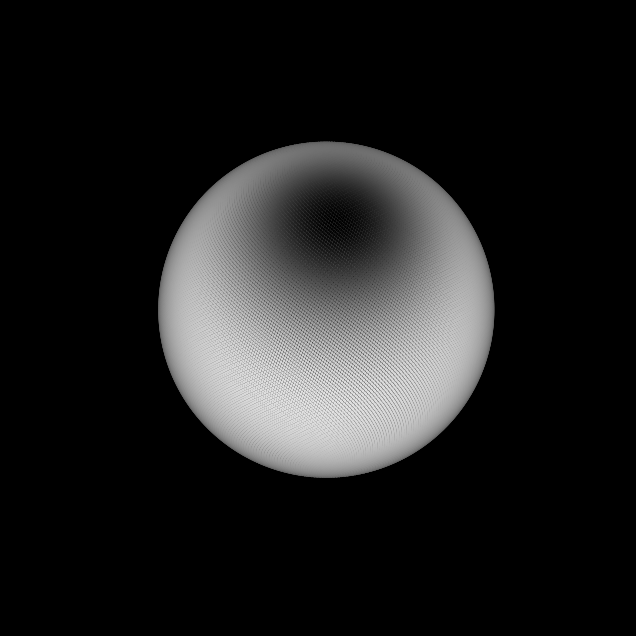

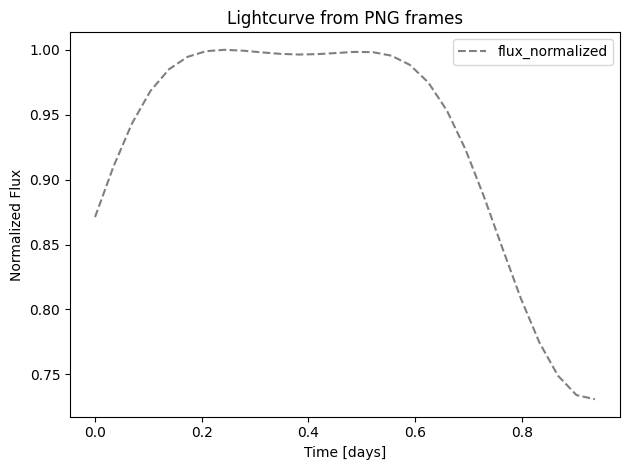

Generate spherical grid...
start render...
Generating ligthcurve..


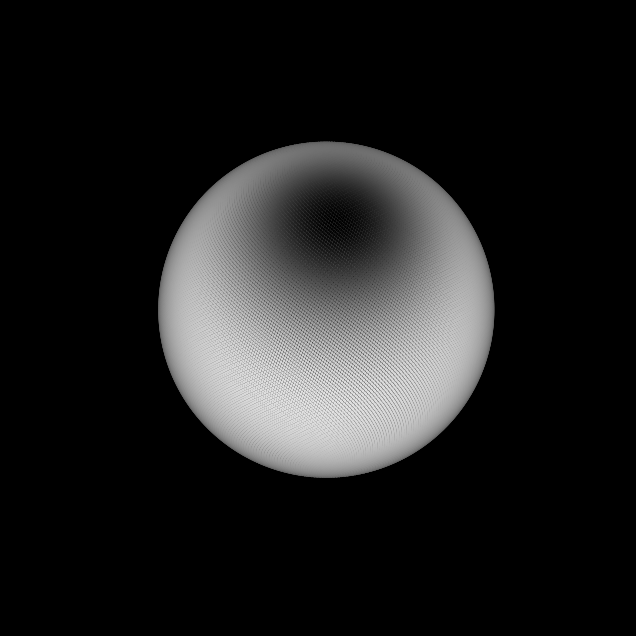

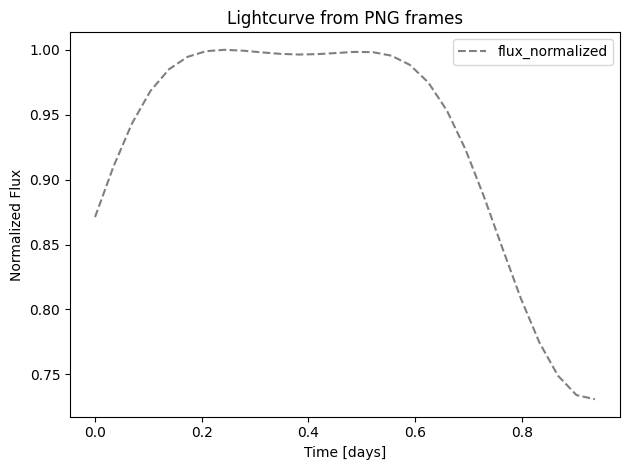

Generate spherical grid...
start render...
Generating ligthcurve..


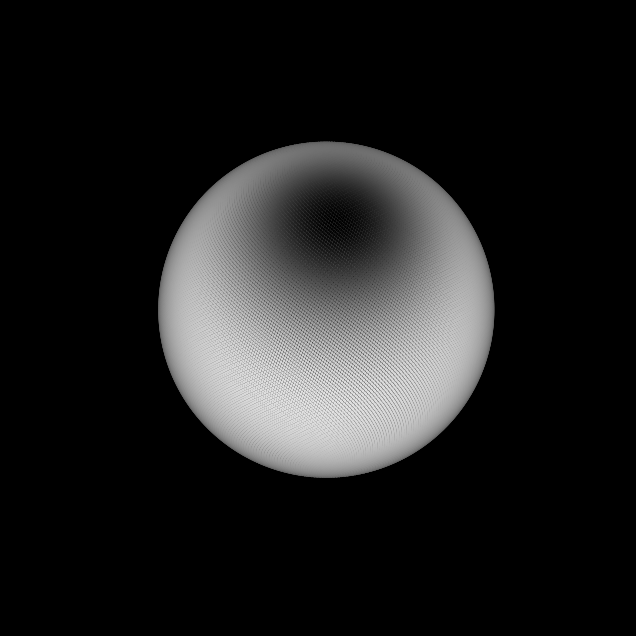

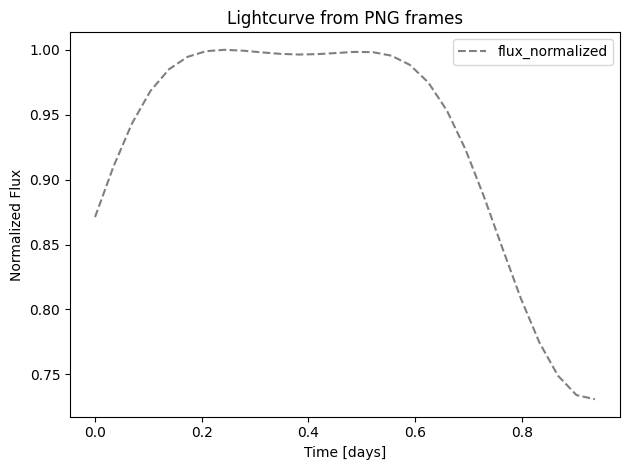

/home/ruben/miniconda3/envs/tesis/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Generate spherical grid...
start render...
Generating ligthcurve..


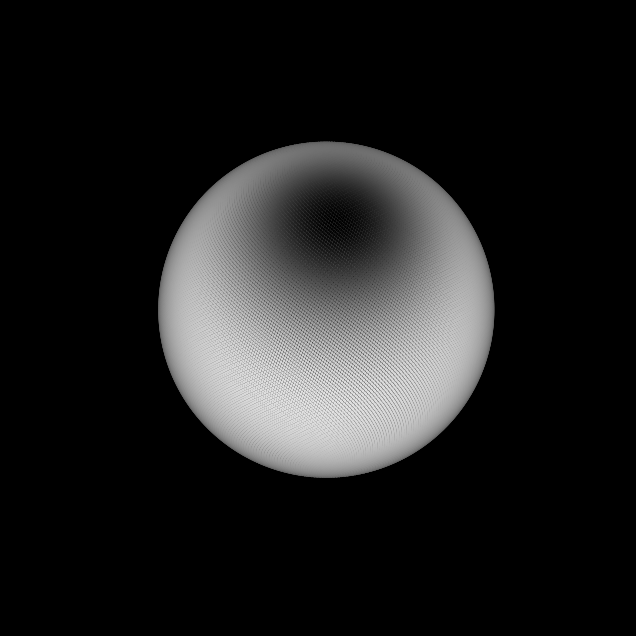

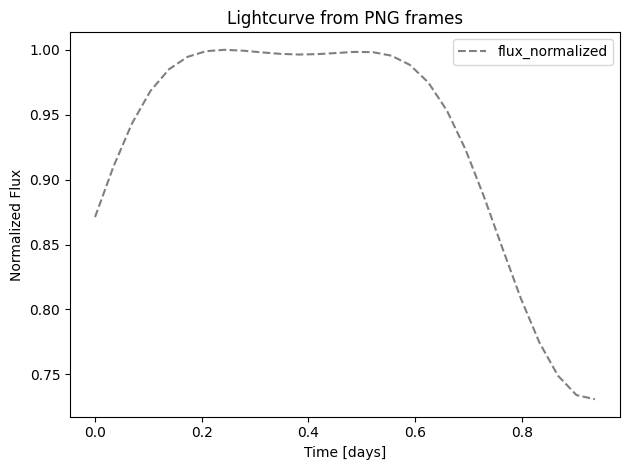

/home/ruben/miniconda3/envs/tesis/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Generate spherical grid...
start render...
Generating ligthcurve..


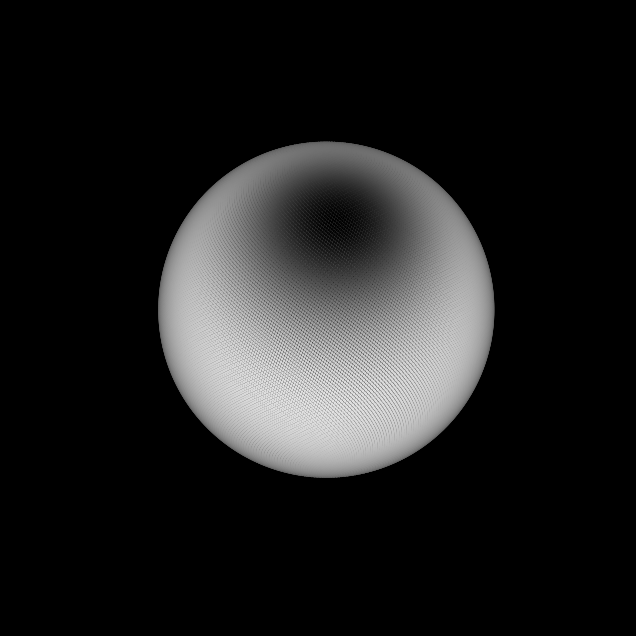

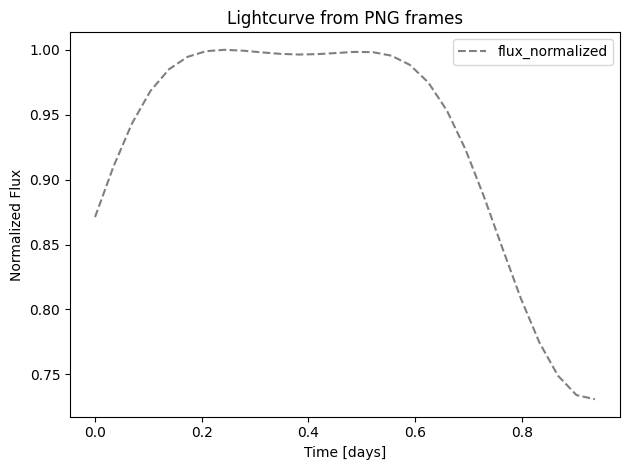

Generate spherical grid...
start render...
Generating ligthcurve..


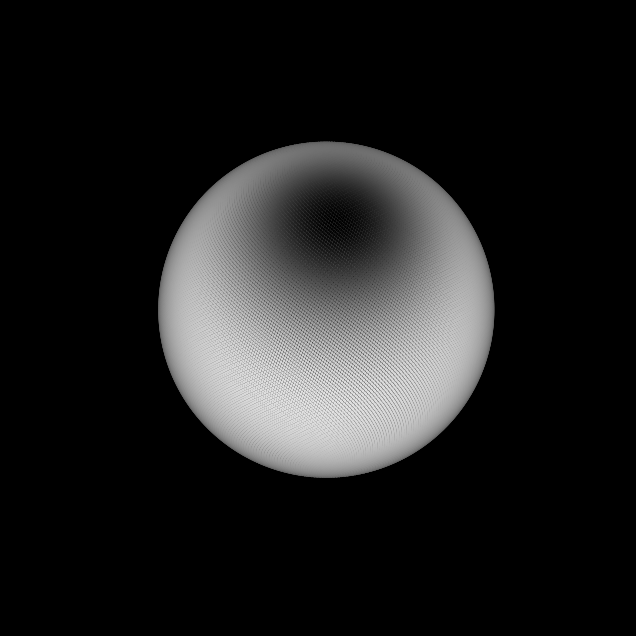

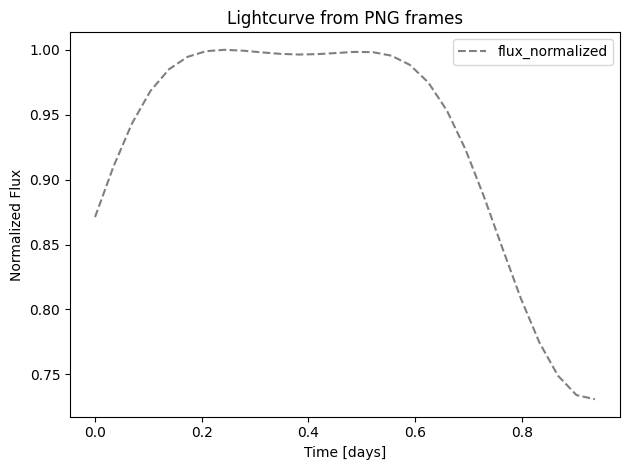

emcee: Exception while calling your likelihood function:
  params: [3.00548374e+01 1.24873710e-02 4.97522189e+00]
  args: (array([0.        , 0.03472222, 0.06944444, 0.10416667, 0.13888889,
       0.17361111, 0.20833333, 0.24305556, 0.27777778, 0.3125    ,
       0.34722222, 0.38194444, 0.41666667, 0.45138889, 0.48611111,
       0.52083333, 0.55555556, 0.59027778, 0.625     , 0.65972222,
       0.69444444, 0.72916667, 0.76388889, 0.79861111, 0.83333333,
       0.86805556, 0.90277778, 0.9375    ]), array([0.87110634, 0.91020195, 0.94339026, 0.96843329, 0.98507453,
       0.99460177, 0.99894623, 1.        , 0.99932603, 0.99802562,
       0.99688347, 0.99636962, 0.99664926, 0.99750904, 0.99837587,
       0.99819737, 0.99550615, 0.98838786, 0.97480716, 0.95326445,
       0.92345435, 0.88697795, 0.84717007, 0.80827436, 0.77442709,
       0.74894094, 0.7339739 , 0.73077717]))
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/ruben/miniconda3/envs/tesis/lib/python3.10/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_37790/2890139170.py", line 54, in lnprob
    return lp + lnlike(theta, days_obs, flux_obs)
  File "/tmp/ipykernel_37790/2890139170.py", line 31, in lnlike
    days_sim, flux_sim = generate_lightcurve(lat, lon, radii)
  File "/tmp/ipykernel_37790/2890139170.py", line 22, in generate_lightcurve
    df_sim = pd.read_csv(filename)
  File "/home/ruben/.local/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/ruben/.local/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/home/ruben/.local/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1620, in __init__
    self._engine = self._ma

FileNotFoundError: [Errno 2] No such file or directory: 'lat_30.1_lon0.0_radii5.0.csv'

In [11]:
import numpy as np
import pandas as pd
import emcee
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Función para cargar datos observados
def load_observed_data():
    df_obs = pd.read_csv("test2.csv")
    return df_obs["Days"].values, df_obs["flux_normalized"].values

# Función wrapper para tu función run
def generate_lightcurve(lat, lon, radii):
    """
    Wrapper para tu función run que devuelve los días y flujo normalizado
    """
    # Ejecutar tu función (esto generará el archivo CSV)
    run(lat, lon, radii)
    
    # Cargar el archivo generado
    filename = f"lat_{lat:.1f}_lon{lon:.1f}_radii{radii:.1f}.csv"
    df_sim = pd.read_csv(filename)
    
    return df_sim["Days"].values, df_sim["flux_normalized"].values

# Función de verosimilitud
def lnlike(theta, days_obs, flux_obs):
    lat, lon, radii = theta
    
    # Generar curva de luz con tus parámetros
    days_sim, flux_sim = generate_lightcurve(lat, lon, radii)
    
    # Interpolar para coincidir en los mismos puntos temporales
    flux_sim_interp = np.interp(days_obs, days_sim, flux_sim)
    
    # Calcular log-verosimilitud
    Terr = 0.005 * np.mean(flux_obs)
    return -0.5 * np.sum((flux_obs - flux_sim_interp) ** 2) / Terr ** 2

# Función de prior
def lnprior(theta):
    lat, lon, radii = theta
    if (-90.0 <= lat <= 90.0 and 
        0.0 <= lon <= 360.0 and 
        0.1 <= radii <= 50.0):
        return 0.0
    return -np.inf

# Función de probabilidad
def lnprob(theta, days_obs, flux_obs):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, days_obs, flux_obs)

# Cargar datos observados
days_obs, flux_obs = load_observed_data()

# Configuración de MCMC
nwalkers = 12
niter = 50  # Reducido por el costo computacional
initial = np.array([30.0, 0.0, 5.0])  # Valores iniciales [lat, lon, radii]
ndim = len(initial)
p0 = [initial + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]

# Función principal de MCMC
def main(p0, nwalkers, niter, ndim, lnprob, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    
    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 20)  # Burn-in más corto
    sampler.reset()
    
    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)
    
    return sampler, pos, prob, state

# Ejecutar MCMC
data = (days_obs, flux_obs)
sampler, pos, prob, state = main(p0, nwalkers, niter, ndim, lnprob, data)

# Analizar resultados
print("MCMC completed!")

# Encontrar los mejores parámetros
best_idx = np.argmax(prob)
best_theta = pos[best_idx]
print(f"Best parameters: lat={best_theta[0]:.2f}, lon={best_theta[1]:.2f}, radii={best_theta[2]:.2f}")

# Graficar resultados con los mejores parámetros
days_sim, flux_sim = generate_lightcurve(*best_theta)

plt.figure(figsize=(10, 5))
plt.plot(days_obs, flux_obs, 'o', label='Observado', alpha=0.7)
plt.plot(days_sim, flux_sim, '-', label='Simulado (mejor ajuste)', linewidth=2)
plt.title("Ajuste de Curva de Luz")
plt.xlabel("Días")
plt.ylabel("Flujo Normalizado")
plt.legend()
plt.tight_layout()
plt.show()

# Graficar las cadenas MCMC
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ["Latitud", "Longitud", "Radio"]
for i in range(ndim):
    ax = axes[i] if ndim > 1 else axes
    ax.plot(sampler.chain[:, :, i].T, alpha=0.4)
    ax.set_ylabel(labels[i])
if ndim > 1:
    axes[-1].set_xlabel("Paso MCMC")
else:
    axes.set_xlabel("Paso MCMC")
plt.tight_layout()
plt.show()